# Derivable 2 – Simulating the Quantum Galton Box and Fitting a Gaussian Distribution

### Overview
This notebook explores the simulation of a quantum Galton box for an arbitrary number of layers. Building on initial examples of 1- and 2-layer circuits, the implementation is extended to support deeper configurations. The resulting output probabilities are analyzed to verify the emergence of a Gaussian distribution—a hallmark of classical random walks.

### Goals
- Define a simple function to generate a quantum Galton board with any number of layers.
- Simulate the circuit using the **Qiskit AerSimulator** backend with a defined number of shots.
- Measure the qubits representing the particle’s position to obtain a **probability distribution** over final positions.
- Convert the measured bitstrings to integer positions for **statistical analysis**.
- Compare the resulting distribution with a **fitted Gaussian curve** to visualize how well the quantum circuit approximates a normal distribution.# Quantum Galton Box Simulation and Gaussian Distribution Fitting





In [1]:
# Standard Imports

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, circuit_drawer
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import os

# Jupyternotebook Magic
%matplotlib inline

# Create output directory
output_dir = "../outputs/Derivable2/"
os.makedirs(output_dir, exist_ok=True)  # Create if doesn't exist

STEP 1: Build the Quantum Galton Box circuit

In [11]:
def build_quantum_galton_box(n_layers: int) -> QuantumCircuit:
    """
    Construct a quantum Galton box circuit with a single qubit coin
    and 'n_layers' position qubits.

    Parameters:
        n_layers (int): Number of layers (depth) in the Galton box.

    Returns:
        QuantumCircuit: The constructed quantum circuit.
    """
    coin = QuantumRegister(1, name='coin')          # Coin qubit
    position = QuantumRegister(n_layers, name='pos') # Position qubits
    classical = ClassicalRegister(n_layers, name='c') # Classical register for measurement

    qc = QuantumCircuit(coin, position, classical)

    # Apply Hadamard and controlled-X gates across each layer
    for i in range(n_layers):
        qc.h(coin[0])                     # Simulate fair coin toss
        qc.cx(coin[0], position[i])      # Move path based on coin result
        if i < n_layers - 1:
            qc.swap(coin[0], position[i])  # Swap coin with position to entangle future path
    # Measure all position qubits
    qc.barrier()
    qc.measure(position, classical)
    
    return qc


STEP 2: Convert Qiskit's bitstring output to integer positions

In [3]:
def convert_counts_to_positions(counts: dict) -> dict:
    """
    Convert binary measurement outcomes (bitstrings) into integer
    position values.

    Parameters:
        counts (dict): Dictionary with bitstrings as keys and
                       measurement counts as values.

    Returns:
        dict: Dictionary with integer positions as keys and counts.
    """
    positions = {}
    for bitstring, count in counts.items():
        # Convert bitstring to integer
        pos = int(bitstring, 2)
        positions[pos] = positions.get(pos, 0) + count
    return positions

Step 3: Plot Quantum Distribution and Compare with Gaussian

In [4]:
def plot_quantum_vs_gaussian(counts: dict, n_layers: int = 5, shots: int = 1024, save_path: str = None) -> None:
    """
    Plot the probability distribution from the quantum Galton box
    and overlay a fitted Gaussian curve for comparison.

    Parameters:
        counts (dict): Measurement counts from quantum simulation.
        n_layers (int): Number of layers in the Galton box.
        shots (int): Total number of measurements (shots).
        save_path (str): Optional path to save the resulting plot.
    """
    # Convert raw counts to position distribution
    positions = convert_counts_to_positions(counts)
    
    x = np.array(sorted(positions.keys()))
    y = np.array([positions[pos] for pos in x]) / shots

    # Fit a Gaussian distribution to the data
    mu, std = norm.fit(np.repeat(x, (y * shots).astype(int)))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(x, y, alpha=0.6, label='Quantum Distribution')
    plt.plot(x, norm.pdf(x, mu, std), 'r--', label=f'Gaussian Fit\nμ={mu:.2f}, σ={std:.2f}')
    plt.xlabel('Final Position (decimal equivalent)')
    plt.ylabel('Probability')
    plt.title(f'Quantum Galton Box vs Gaussian Fit (Layers={n_layers})')
    plt.legend()
    plt.grid(True)

    # Save plot if path provided
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

Step 4: Execute the Simulation and Save Results

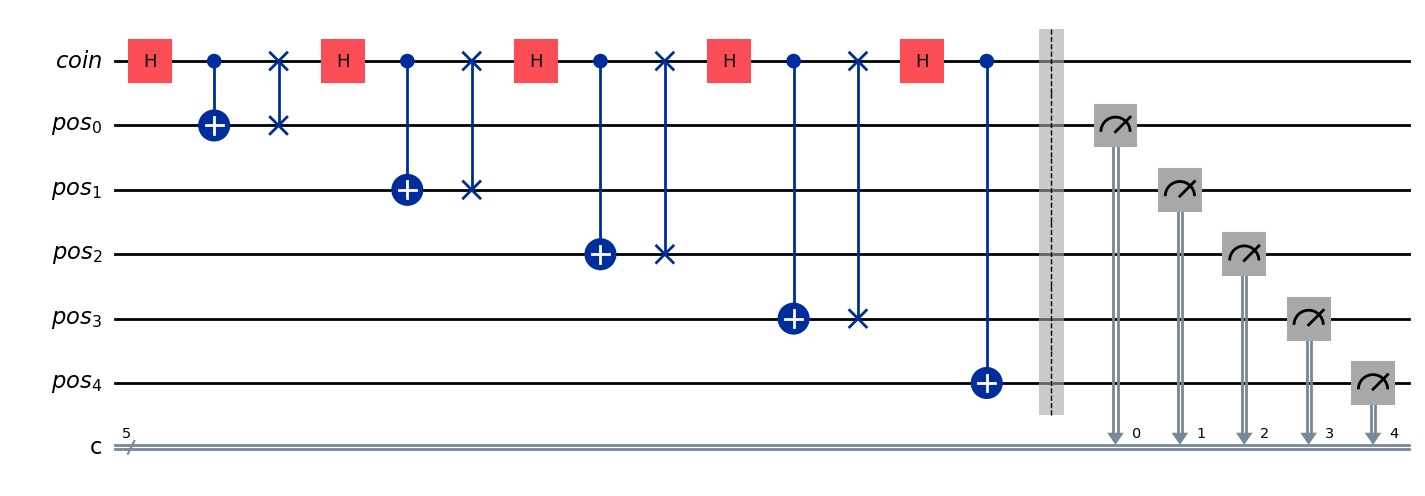

In [12]:
# Configuration
n_layers = 5       # Number of layers in the Galton box
shots = 1024       # Number of measurement shots

# Build the quantum circuit
qc = build_quantum_galton_box(n_layers)

# Save the circuit diagram as an image
# circuit_path = "/home/sarojray/Downloads/womanium2025/QuantumGaltonBox/results/quantum_galton_box_circuit.png"
circuit_path = os.path.join(output_dir, "quantum_galton_box_circuit.png")
circuit_drawer(qc, output='mpl', filename=circuit_path)

# Simulate the circuit using Qiskit's Aer simulator
simulator = AerSimulator()
compiled_qc = transpile(qc, simulator)
result = simulator.run(compiled_qc, shots=shots).result()
counts = result.get_counts()



[✓] Plot saved to: ../outputs/Derivable2/quantum_vs_gaussian_distribution.png


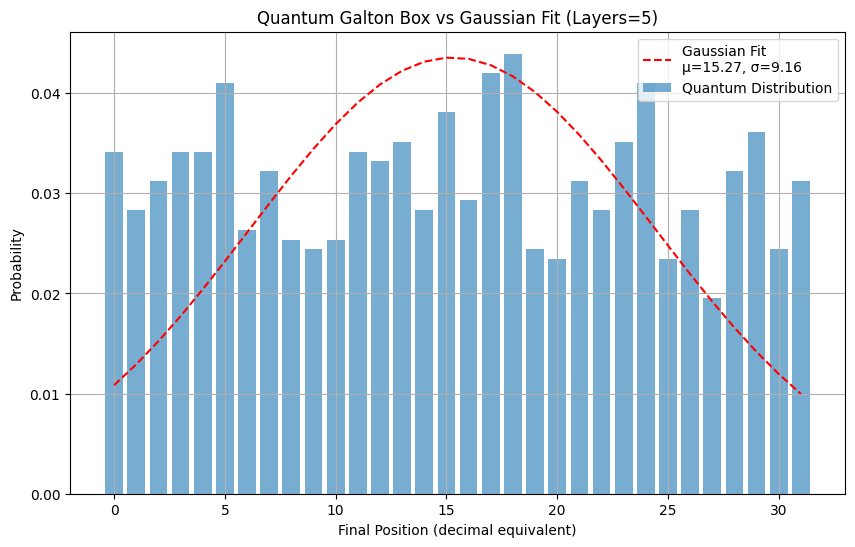

In [10]:
# Save and show the distribution plot
# save_path =  "/home/sarojray/Downloads/womanium2025/QuantumGaltonBox/results/quantum_vs_gaussian_distribution.png"
plot_path = os.path.join(output_dir, "quantum_vs_gaussian_distribution.png")
print(f"[✓] Plot saved to: {plot_path}")
plt.show()

# Gaussain plot
plot_quantum_vs_gaussian(counts, n_layers=n_layers, shots=shots, save_path=plot_path)